## GDL demo notebook

Demonstration of GDL [(gnudatalanguage)](https://github.com/gnudatalanguage/gdl)

This notebook creates a Shepp-Logan phantom, projects it and then performs an FBP reconstruction.

In [1]:
;; L.A. Shepp and B.F. Logan, “The Fourier reconstruction of a head section,”
;; IEEE Trans. Nucl. Sci. 21(3), 21–43 (1974).
function shepplogan, size = size

  if NOT keyword_set(size) then size = 256

  phantom = fltarr(size,size)

  tmp  = (findgen(size)-((size-1)/2.0)) / (size/2.0)
  xcor = rebin(tmp,size,size)
  ycor = rebin(transpose(tmp),size,size)
  tmp  = fltarr(size,size)
  
  aa={cx: 0.0,  cy: 0.0,    maj:0.69,   min:0.92,  theta:  0.0, val: 2.0 }
  bb={cx: 0.0,  cy:-0.0184, maj:0.6624, min:0.874, theta:  0.0, val:-0.98}
  cc={cx: 0.22, cy: 0.0,    maj:0.11,   min:0.31,  theta:-18.0, val:-0.02}
  dd={cx:-0.22, cy: 0.0,    maj:0.16,   min:0.41,  theta: 18.0, val:-0.02}
  ee={cx: 0.0,  cy: 0.35,   maj:0.21,   min:0.25,  theta:  0.0, val:-0.01}
  ff={cx: 0.0,  cy: 0.1,    maj:0.046,  min:0.046, theta:  0.0, val:-0.01}
  gg={cx: 0.0,  cy:-0.1,    maj:0.046,  min:0.046, theta:  0.0, val:-0.01}
  hh={cx:-0.08, cy:-0.605,  maj:0.046,  min:0.023, theta:  0.0, val:-0.01}
  ii={cx: 0.0,  cy:-0.605,  maj:0.023,  min:0.023, theta:  0.0, val:-0.01}
  jj={cx: 0.06, cy:-0.605,  maj:0.023,  min:0.046, theta:  0.0, val:-0.01}

  list = [aa,bb,cc,dd,ee,ff,gg,hh,ii,jj]
  for n = 0, n_elements(list)-1 do begin

     tmp = ((xcor-list[n].cx) / list[n].maj)^2 $
           + ((ycor-list[n].cy) / list[n].min)^2
     
     if list[n].theta NE 0 then begin
        nx = (size-1) * (list[n].cx + 1) / 2
        ny = (size-1) * (list[n].cy + 1) / 2
        tmp = rot(tmp, -list[n].theta, 1, nx, ny, /interp, /pivot)
     endif
     
     phantom[where(tmp LE 1.0)] += list[n].val
     
  endfor
  
  return, phantom < 1.1
  
end

In [2]:
;; Enable inline plotting
!inline=1

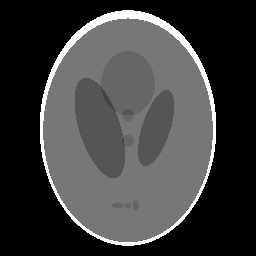

In [3]:
phantom = shepplogan()
window, 0, xsize=256, ysize=256
tvscl, phantom > 0.95

Now we define simple forward and backprojection functions:

In [4]:
function proj, image, angle

    sino_size_x = max(size(image,/dim))
    sino_size_y = n_elements(angle)

    sino = fltarr(sino_size_x, sino_size_y)
    
    for aa=0, n_elements(angle)-1 do begin
    
        sino[*,aa] = total(rot(image, angle[aa], /interp), 2)
    
    endfor

    return, sino
    
end

In [5]:
function back, sino, angle

    image_size = n_elements(sino[*,0])
    image = fltarr(image_size,image_size)

    for aa=0, n_elements(angle)-1 do begin
    
        image += rot(rebin(sino[*,aa],[image_size,image_size]), -angle[aa], /interp)
    
    endfor

    return, image / n_elements(angle)

end

This allows us to create a sinogram:

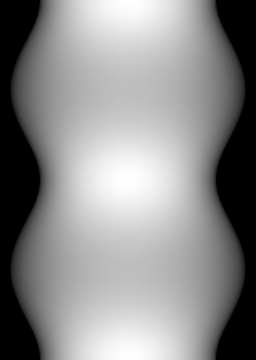

In [6]:
angles = findgen(360)
sino = proj(phantom, angles)
window, 0, xsize=256, ysize=360
tvscl, sino

On this we can apply a simple FBP reconstruction:

In [7]:
;; G.L. Zeng, “Revisit of the Ramp Filter,”
;; IEEE Trans. Nucl. Sci. 62(1), 131–136 (2015).
function fbp, sino, angles
  
  ntot = n_elements(sino[*,0])
  nang = n_elements(sino[0,*])
  npos = ntot / 2 + 1           ; integer division needed !
  nneg = ntot - npos

  freq = findgen(ntot)
  freq[npos:ntot-1] = REVERSE(freq[1:nneg])
  freq[0] = 1

  filter = -1 / (!pi * freq)^2
  filter[where(freq mod 2 EQ 0)] *= -0.0
  filter[0] = 0.25

  filter = abs(fft(filter)) * ntot
  filter[ntot/4:ntot/4+ntot/2-1] *= 0.0
  filter = rebin(filter,ntot,nang)

  ;; apply filter to the sinogram
  fsino  = fft(sino,  dim=1)
  fsino *= filter
  fsino  = fft(fsino, dim=1, /overwrite, /inverse)
  fsino  = !pi * real_part(fsino)

  ;; backproject the filtered sinogram
  return, back(fsino, angles)

end

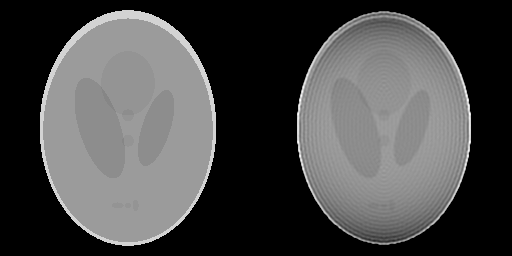

In [8]:
reconstruction = fbp(sino, angles)
window, 0, xsize=512, ysize=256

tvscl, [phantom, reconstruction] > 0.8

### The end